# Stock Trading App Tutorial Part 7-9

## Part 7: [Charting and Filtering](https://www.youtube.com/watch?v=fYf3EeupuMo&list=PLvzuUVysUFOuoRna8KhschkVVUo2E2g6G&index=8)
- Chart widget for stock_detail.html.
- TradingView provides free embeddable widget to use on web page, can modify to focus on data you have.
    - Requires exchange in symbol parameter (e.g. "symbol": "NASDAQ:AAPL"), which is not in database.
    - Modify stock table to add exchange pattern, update `populate_stocks.py` to use exchange value returned from Alpaca.
    - Change to New York Timezone for consistency.
    - https://www.tradingview.com/widget/advanced-chart/
- Provided TradingView chart requires `exchange` to display corresponding symbol.
- Add `exchange` to database:
```python
# create_db.py
# ...
cursor.executescript("""
    CREATE TABLE IF NOT EXISTS stock (
        id INTEGER PRIMARY KEY, 
        symbol TEXT NOT NULL UNIQUE, 
        name TEXT NOT NULL, 
        exchange TEXT NOT NULL
    );
    CREATE TABLE IF NOT EXISTS stock_price (
        id INTEGER PRIMARY KEY, 
        stock_id INTEGER, 
        date NOT NULL, 
        open NOT NULL, 
        high NOT NULL, 
        low NOT NULL, 
        close NOT NULL, 
        volume NOT NULL, 
        FOREIGN KEY (stock_id) REFERENCES stock (id)
    );
""")
```
- New TradingView widget placed between `h1` and `h2` in `stock_detail.html`:
```html
<!-- TradingView Widget BEGIN -->
<div class="tradingview-widget-container" id="tv_chart_container"></div>
<script type="text/javascript" src="https://s3.tradingview.com/external-embedding/embed-widget-advanced-chart.js" async></script>
<script type="text/javascript">
    new TradingView.widget(
        {
            "width": "980",
            "height": "610", 
            // "symbol": "NASDAQ:AAPL",
            "symbol": "{{ stock.exchange }}:{{ stock.symbol }}", // Exchange added to database
            "interval": "D",
            "timezone": "America/New_York",
            "theme": "light",
            "style": "1",
            "locale": "en",
            "allow_symbol_change": true,
            "calendar": false,
            "support_host": "https://www.tradingview.com",
            "studies": [
                "MASimple@tv-basicstudies"
            ],
            "container_id": "tv_chart_container",
            "library_path": "/charting_library/",
            "locale": "en",            
            "branding_code": "<!-- TradingView Widget BEGIN --><div class='tradingview-widget-container'><div id='tv_chart_container'></div><div class='tradingview-widget-copyright'><a href='https://www.tradingview.com' rel='noopener nofollow' target='_blank'><span class='blue-text'>Track all markets on TradingView</span></a></div></div><!-- TradingView Widget END -->"
        }
    );
</script>
<!-- TradingView Widget END -->
```
## Bullish and bearish ideas
- UI filter to screen stock table for various conditions.
- Achieved by HTML form into `index.html`.
    - `method="get"` will put query string into URL.
```html
<!-- ... -->
<h1 class="ui center aligned header">Stock List</h1>
<form method="get">
    <select name="filter">
        <option value="">All Stocks</option>
        <option value="new_intraday_highs">New Intraday Highs</option>
        <option value="new_closing_highs">New Closing Highs</option>
        <option value="new_intraday_lows">New Intraday Lows</option>
        <option value="new_closing_lows">New Closing Lows</option>
    </select>
    <input type="submit"/>
</form>
<table class="ui selectable striped table">
<!-- ... -->
```
- Need to process submission.
    - Form value "filter" will be in URL.
    - On Python, can access query parameters under request object.
- If `filter` value is not `False`, SQL query is modified accordingly, otherwise returns full list. (If-else)
- "New Closing Highs"
    - `JOIN ON` to get actual stock symbols.
    - `max(close)` to get maximum close of each stock in database.
    - Only get maximum close for every stock for current date.
```python
cursor.execute("""
    SELECT * FROM (
        SELECT symbol, name, stock_id, max(close), date 
        FROM stock_price JOIN stock ON stock.id = stock_price.stock_id 
        GROUP BY stock_id
        ORDER BY symbol
    ) WHERE date = ?
""", (date.today().isoformat(),))
```
- Creating strategies for usage within each stock page.
- `create_db.py`
```python
# ... 
cursor.executescript("""
    CREATE TABLE IF NOT EXISTS strategy (
        id INTEGER PRIMARY KEY, 
        name NOT NULL, 
    );
    CREATE TABLE IF NOT EXISTS stock_strategy (
        stock_id INTEGER NOT NULL, 
        strategy_id INTEGER NOT NULL, 
        FOREIGN KEY (stock_id) REFERENCES stock (id)
        FOREIGN KEY (strategy_id) REFERENCES strategy (id)
    );
""")
strategies = ["opening_range_breakout", "opening_range_breakdown"]
for strategy in strategies: 
    cursor.execute("INSERT INTO strategy (name) VALUES (?)", (strategy,))
# ... 
```

- `main.py`
    - Requires `Form` from FastAPI for post request for processing form. (https://fastapi.tiangolo.com/tutorial/request-forms/)
    - `apply_strategy` redirects to `strategy` after processing.
    - New page `strategy.html` required that shows which stocks have the selected strategy applied.
```python
@app.get("/")
# ... 
cursor = connection.cursor() 
cursor.execute("""
    SELECT * FROM strategy
""")
strategies = cursor.fetchall() 
# ...
@app.post("/apply_strategy")
def apply_strategy(strategy_id: int = Form(...), stock_id: int = Form(...)): 
    connection = sqlite3.connect(config.DB_FILE) 
    cursor = connection.cursor() 
    cursor.execute("""
        INSERT INTO stock_strategy (stock_id, strategy_id) VALUES (?, ?) 
    """, (stock_id,strategy_id)) 
    connection.commit()
    return RedirectResponse(url=f"/strategy/{strategy_id}", status_code=303) # Redirect to another URL after recieving response

@app.get("/stock/{symbol}")
def strategy(request: Request, strategy_id): 
    connection = sqlite3.connect(config.DB_FILE) 
    connection.row_factory = sqlite3.Row 
    cursor = connection.cursor() 

    cursor.execute("""
        SELECT id, name FROM strategy WHERE id = ?
    """, (strategy_id,))
    strategy = cursor.fetchone() 
    
    cursor.execute("""
        SELECT symbol, name FROM stock JOIN stock_strategy ON stock_strategy.stock_id = stock.id WHERE strategy_id = ?
    """, (strategy_id,))
    stocks = cursor.fetchall() 
    
    return templates.TemplateResponse(request=request, name="strategy.html", context={"stocks": stocks, "strategy": strategy})
```

- `stock_detail.html`
    - Will run `@app.post("/apply_strategy")` from `main.py`
```html
<h2>Strategies</h2> 
<form method="post" action="/apply_strategy">
    <select name="strategy_id">
    {% for strategy in strategies %}
        <option value="{{ strategy.id }}">{{ strategy.name }}</option>
    {% endfor %}
    </select>
    <input type="hidden" name="stock_id" value="{{ stock.id }}" />
    <input type="submit" value="Apply Strategy"/>
</form>
```

## Part 8: [Opening Range Breakout (ORB)](https://www.youtube.com/watch?v=RZ_4OI_K6Aw&list=PLvzuUVysUFOuoRna8KhschkVVUo2E2g6G&index=10)
- Calculate the High and Low of the opening 15 minute bar for each stock in  `stock_strategy` table, then execute a bracket order if the price breaks out of the given range.
    - Polygon integration to get first 15 min with Alpaca API.
    - Polygon.io is exclusive, will need the following to achieve a similar result.
```python
import config
from alpha_vantage.timeseries import TimeSeries
def get_minute_data(ticker):
    ts = TimeSeries(key=config.ALPHA_KEY, output_format='pandas', indexing_type='date')
    df, _ = ts.get_intraday(
        ticker, interval='1min', outputsize='full')
    df.rename(columns={"1. open": "open", "2. high": "high", "3. low": "low", "4. close": "close", "5. volume": "volume",  "date": "date"}, inplace=True)
    df = df.iloc[::-1]
    return df
```
- https://www.warriortrading.com/opening-range-breakout/
- `opening_range_breakout.py`
    - Obtain stock symbols of interest.
    - Fetch minute bars for each stock symbol with `REST()`.
    - Obtain range of values within first 15 minutes (Maximum high, minimum low).
    - Find first time in day where price crosses above high, then enter trade when that happens.
    - For more aggressive plans, could use: 1.5 of opening range, trailing stop, e.t.c.
    - Overall setting profit taking point and stop loss.
    - Want to apply ORB strategy every minute through cron.
```python
import sqlite3 
import config 
import alpaca_trade_api as tradeapi
from datetime import date 
import pytz

connection = sqlite3.connect(config.DB_FILE) 
connection.row_factory = sqlite3.Row 
cursor = connection.cursor() 

cursor.execute("""
    SELECT id FROM strategy WHERE name = "opening_range_breakout"
""")
strategy_id = cursor.fetchone()["id"]

cursor.execute("""
    SELECT symbol, name 
    FROM stock JOIN stock_strategy ON stock_strategy.stock_id = stock.id 
    WHERE stock_strategy.strategy_id = ? 
""", (strategy_id, ))
stocks = cursor.fetchall()
symbols = [stock["symbol"] for stock in stocks] # Obtain stock symbols of interest
print(symbols)

api = tradeapi.REST(config.API_KEY, config.SECRET_KEY, base_url = config.API_URL, api_version = "v2") # config.py variables 

current_date = date.date.today(pytz.timezone('US/Eastern')).isoformat()
start_minute_bar = f"{current_date} 09:30:00-04:00"
end_minute_bar = f"{current_date} 09:45:00-04:00"

orders = api.list_orders()
existing_order_symbols = [order.symbol for order in orders]

for symbol in symbols: 
    # minute_bars = api.polygon.historic_agg_v2(symbol, 1, "minute", _from = current_date, to = current_date).df # CANNOT BE APPLIED DUE TO NEEDING POLYGON
    minute_bars = get_minute_data(symbol) # Fetch minute bars for each stock symbol 
    print(symbol)
    # print(minute_bars) # Minute bars for given time range

    # Obtain first 15 minutes 
    opening_range_mask = (minute_bars.index >= start_minute_bar) & (minute_bars.index < end_minute_bar)
    opening_range_bars = minute_bars.loc[opening_range_mask]
    print(opening_range_bars)

    # Obtain range of values within first 15 minutes (Maximum high, minimum low)
    opening_range_low = opening_range_bars["low"].min()
    opening_range_high = opening_range_bars["high"].max()
    opening_range = opening_range_high - opening_range_low
    print(opening_range_low)
    print(opening_range_high)
    print(opening_range)

    # After first 15 minutes 
    after_opening_range_mask = minute_bars.index >= end_minute_bar
    after_opening_range_bars = minutes.loc[after_opening_range_mask]
    after_opening_bar_breakout = after_opening_range_bars[after_opening_range_bars["close"] > opening_range_high]
    
    if not after_opening_bar_breakout.empty: 
        if symbol not in existing_order_symbols: 
            limit_price = after_opening_bar_breakout.iloc[0]["close"]
            print(limit_price)
            print(f"Placing order for {symbol} at {limit_price}, closed above {opening_range_high} at {after_opening_bar_breakout.iloc[0]}")
            api.submit_order(
                symbol=symbol,
                side='buy',
                type='limit',
                qty='100',
                time_in_force='day',
                order_class='bracket',
                limit_price=limit_price,
                take_profit=dict(
                    limit_price=limit_price + opening_range,
                ),
                stop_loss=dict(
                    limit_price=limit_price - opening_range,
                )
            )
        else: 
            print(f"Already an order for {symbol}, will skip.")
```

### Example 
- Enter trade if close within minute is above 247.5. (e.g. 248.80)
- Set target price as 247.5 + 3.56 = 251.06
- Stop loss of 243.94
- If price never went above 247.5, would never have entered trade, no loss.
- Expecting more wins than losses

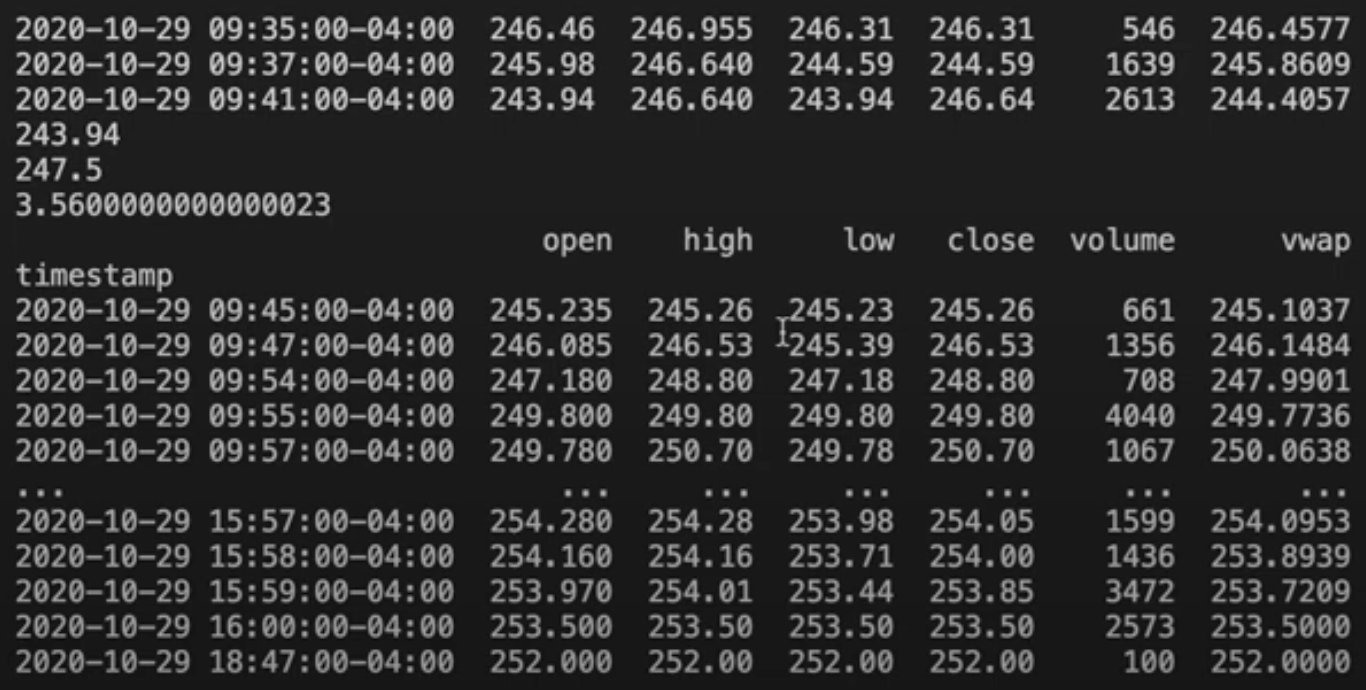

## Part 9: [Costly Bugs](https://www.youtube.com/watch?v=8PUP7dsvW3A&list=PLvzuUVysUFOuoRna8KhschkVVUo2E2g6G&index=11)
- Multiple detrimental trades done when only 1 trade should have been executed.
- Bug is that `existing_order_symbols` is empty.
- According to documentation (https://alpaca.markets/deprecated/docs/api-documentation/api-v2/orders/), order status default is `open`, thus system assumes that there are no existing orders.
- `opening_range_breakout.py`
```python
# ...
current_date = date.date.today(pytz.timezone('US/Eastern')).isoformat()
start_minute_bar = f"{current_date} 09:30:00-04:00"
end_minute_bar = f"{current_date} 09:45:00-04:00"

orders = api.list_orders(status="all", after=f"{current_date}T13:30:00Z")
existing_order_symbols = [order.symbol for order in orders]
# ...
```